In [30]:
##tensorflow - A powerful library for machine learning and deep learning,Building and training neural networks
##matplotlib - Plotting graphs, Visualizing training history , Displaying images.
##pandas - A library for data manipulation and analysis
## seaborn - A library built on top of Matplotlib for statistical data visualization.

In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [32]:
training_set = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode="categorical",
    class_names=None, 
    color_mode="rgb",
    batch_size=32, ## (no of images in 1 batch)
    image_size=(128, 128),
    shuffle=True,   ## avoid biasness(random order)
    seed=None,  ## same sequence
    validation_split=None,  ##entire dataset is used for training
    subset=None,   
    interpolation="bilinear",  ## method to resize images
    follow_links=False,
    crop_to_aspect_ratio=False,   ##image is resized directly to the target size
)

Found 36998 files belonging to 20 classes.


In [33]:
validation_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 9248 files belonging to 20 classes.


In [ ]:
# 🌱 Data Augmentation Layer
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255), 
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1, 0.1),
])

# Apply data augmentation to training set
augmented_training_set = training_set.map(lambda x, y: (data_augmentation(x, training=True), y))

In [34]:
training_set

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>

In [35]:
##x is a tensor containing a batch of images.
## y is a tensor containing the corresponding labels.

In [36]:
for x,y in training_set:
    print(x,x.shape)
    print(y,y.shape)
    break

tf.Tensor(
[[[[138.75 124.75 137.75]
   [122.   108.   121.  ]
   [140.   126.   139.  ]
   ...
   [149.5  125.5  138.5 ]
   [124.75 100.75 113.75]
   [133.25 109.25 122.25]]

  [[144.25 130.25 143.25]
   [138.   124.   137.  ]
   [130.5  116.5  129.5 ]
   ...
   [150.25 126.25 139.25]
   [132.75 108.75 121.75]
   [136.5  112.5  125.5 ]]

  [[155.   141.   154.  ]
   [155.5  141.5  154.5 ]
   [161.25 147.25 160.25]
   ...
   [136.75 112.75 125.75]
   [153.5  129.5  142.5 ]
   [134.75 110.75 123.75]]

  ...

  [[181.5  170.5  184.5 ]
   [179.   168.   182.  ]
   [178.   167.   181.  ]
   ...
   [155.25 141.25 156.25]
   [153.   139.   154.  ]
   [154.   140.   155.  ]]

  [[180.   169.   183.  ]
   [182.5  171.5  185.5 ]
   [186.75 175.75 189.75]
   ...
   [158.75 144.75 159.75]
   [149.   135.   150.  ]
   [144.25 130.25 145.25]]

  [[194.   183.   197.  ]
   [189.25 178.25 192.25]
   [192.75 181.75 195.75]
   ...
   [157.5  143.5  158.5 ]
   [160.75 146.75 161.75]
   [147.25 133.25 14

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Replacing your augmentation with preprocessing for MobileNetV2
preprocessing = tf.keras.Sequential([
    layers.Rescaling(1./255),  # OR use preprocess_input for better results
])

train_ds = training_set.map(lambda x, y: (data_augmentation(x, training=True), y))
val_ds = validation_set.map(lambda x, y: (preprocessing(x), y))

base_model = MobileNetV2(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(20, activation='softmax')  # 20 classes in your case
])


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                 

In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop, checkpoint]
)



Epoch 1/10
1157/1157 [==============================] - 2421s 2s/step - loss: 1.2088 - accuracy: 0.6136 - val_loss: 0.6268 - val_accuracy: 0.7835
Epoch 2/10
1157/1157 [==============================] - 1546s 1s/step - loss: 0.4663 - accuracy: 0.8467 - val_loss: 0.4150 - val_accuracy: 0.8662
Epoch 3/10
1157/1157 [==============================] - 1551s 1s/step - loss: 0.2921 - accuracy: 0.9033 - val_loss: 0.2823 - val_accuracy: 0.9119
Epoch 4/10
1157/1157 [==============================] - 1569s 1s/step - loss: 0.2027 - accuracy: 0.9312 - val_loss: 0.2625 - val_accuracy: 0.9091
Epoch 5/10
1157/1157 [==============================] - 1552s 1s/step - loss: 0.1574 - accuracy: 0.9478 - val_loss: 0.2328 - val_accuracy: 0.9258
Epoch 6/10
1157/1157 [==============================] - 1583s 1s/step - loss: 0.1275 - accuracy: 0.9569 - val_loss: 0.1599 - val_accuracy: 0.9486
Epoch 7/10
1157/1157 [==============================] - 1593s 1s/step - loss: 0.1086 - accuracy: 0.9633 - val_loss: 0.2467 -

In [54]:
#Model Evaluation on Training set
train_loss,train_acc = model.evaluate(training_set)

1157/1157 [==============================] - 343s 296ms/step - loss: 0.1692 - accuracy: 0.9488


In [55]:
print(train_loss,train_acc)

0.16918404400348663 0.9487810134887695


In [56]:
#Model on Validation set
val_loss,val_acc = model.evaluate(validation_set)

289/289 [==============================] - 86s 296ms/step - loss: 0.3260 - accuracy: 0.9126


In [57]:
print(val_loss,val_acc)

0.3260457515716553 0.9126297831535339


In [58]:
##SAVING MODEL

In [59]:
model.save("trained_model.keras")

In [60]:
history.history

{'loss': [1.2088149785995483,
  0.4662705659866333,
  0.2921113669872284,
  0.20274430513381958,
  0.1574249118566513,
  0.12749890983104706,
  0.10863500088453293,
  0.08538512885570526,
  0.07316683977842331,
  0.06340768188238144],
 'accuracy': [0.6135737299919128,
  0.8466944098472595,
  0.9032920598983765,
  0.9311584234237671,
  0.94775390625,
  0.9569165706634521,
  0.9633223414421082,
  0.9717011451721191,
  0.976241946220398,
  0.9794042706489563],
 'val_loss': [0.6267673373222351,
  0.4150174558162689,
  0.28225576877593994,
  0.2625153064727783,
  0.2328130304813385,
  0.15990807116031647,
  0.2467176765203476,
  0.23368321359157562,
  0.17158184945583344,
  0.3260457515716553],
 'val_accuracy': [0.7835207581520081,
  0.8662413358688354,
  0.9118728637695312,
  0.9090614318847656,
  0.9258217811584473,
  0.9486375451087952,
  0.9235510230064392,
  0.9302551746368408,
  0.9489619135856628,
  0.9126297831535339]}

In [61]:
#Recording History in json
import json
with open("training_hist.json","w") as f:
    json.dump(history.history, f)

In [62]:
history.history['val_accuracy']

[0.7835207581520081,
 0.8662413358688354,
 0.9118728637695312,
 0.9090614318847656,
 0.9258217811584473,
 0.9486375451087952,
 0.9235510230064392,
 0.9302551746368408,
 0.9489619135856628,
 0.9126297831535339]

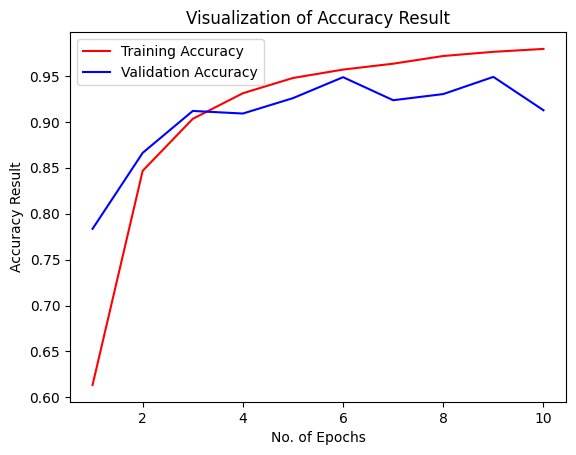

In [63]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs,history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy Result")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

In [64]:
##Some other metrics for model evaluation

In [65]:
class_name = validation_set.class_names
class_name

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [66]:
test_set = tf.keras.utils.image_dataset_from_directory(
    'valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 9248 files belonging to 20 classes.


In [67]:
y_pred = model.predict(test_set)
y_pred,y_pred.shape

289/289 [==============================] - 84s 289ms/step


(array([[9.99998569e-01, 1.85680649e-09, 1.73805209e-12, ...,
         2.01167360e-12, 1.05728575e-14, 1.70163675e-10],
        [9.99998927e-01, 9.17012642e-07, 2.73029273e-11, ...,
         6.74324666e-15, 4.96065862e-15, 3.18438418e-12],
        [9.99996066e-01, 5.43618853e-07, 8.67168670e-10, ...,
         2.29245269e-11, 2.39787357e-11, 2.53952942e-10],
        ...,
        [1.23056730e-12, 1.30874935e-18, 4.11731901e-13, ...,
         1.65297752e-16, 2.32419064e-16, 1.00000000e+00],
        [1.03703413e-09, 1.78151654e-15, 6.13739129e-11, ...,
         5.80979546e-13, 5.80102589e-13, 1.00000000e+00],
        [6.78492040e-10, 3.09474078e-11, 1.79963400e-09, ...,
         1.02971180e-10, 1.09369065e-08, 9.99800265e-01]], dtype=float32),
 (9248, 20))

In [68]:
predicted_categories = tf.argmax(y_pred,axis=1)

In [69]:
predicted_categories

<tf.Tensor: shape=(9248,), dtype=int64, numpy=array([ 0,  0,  0, ..., 19, 19, 19], dtype=int64)>

In [70]:
true_categories = tf.concat([y for x,y in test_set],axis=0)
true_categories

<tf.Tensor: shape=(9248, 20), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [71]:
Y_true = tf.argmax(true_categories,axis=1)
Y_true

<tf.Tensor: shape=(9248,), dtype=int64, numpy=array([ 0,  0,  0, ..., 19, 19, 19], dtype=int64)>

In [72]:
from sklearn.metrics import classification_report,confusion_matrix

In [73]:
print(classification_report(Y_true,predicted_categories,target_names=class_name))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.90      0.93       504
                                 Apple___Black_rot       0.97      0.97      0.97       497
                          Apple___Cedar_apple_rust       0.95      0.98      0.97       440
                                   Apple___healthy       0.99      0.89      0.94       502
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.97      0.78      0.86       410
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.94      0.94      0.94       477
                            Corn_(maize)___healthy       0.95      1.00      0.97       465
                            Peach___Bacterial_spot       0.94      0.93      0.93       459
                                   Peach___healthy       0.90      1.00      0.

In [74]:
cm = confusion_matrix(Y_true,predicted_categories)
cm

array([[453,  10,   4,   3,   0,   0,   0,   2,   7,   9,   0,   0,   4,
         10,   0,   0,   0,   0,   1,   1],
       [  4, 480,   0,   1,   0,   0,   0,   0,   0,   7,   0,   2,   3,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 431,   0,   0,   0,   0,   0,   0,   1,   0,   0,   3,
          0,   0,   0,   1,   2,   2,   0],
       [  7,   4,   0, 448,   0,   0,   0,   0,   4,  22,   0,   8,   2,
          5,   0,   0,   1,   1,   0,   0],
       [  1,   0,   7,   0, 320,   2,  27,  16,   3,   2,   0,   0,  31,
          0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0,   1, 471,   1,   0,   0,   0,   0,   0,   4,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   9,   0, 449,   8,   4,   0,   0,   0,   7,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 465,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  2,   0,   4,   0,   0,   0,   0,   1, 425,   3,   0,  

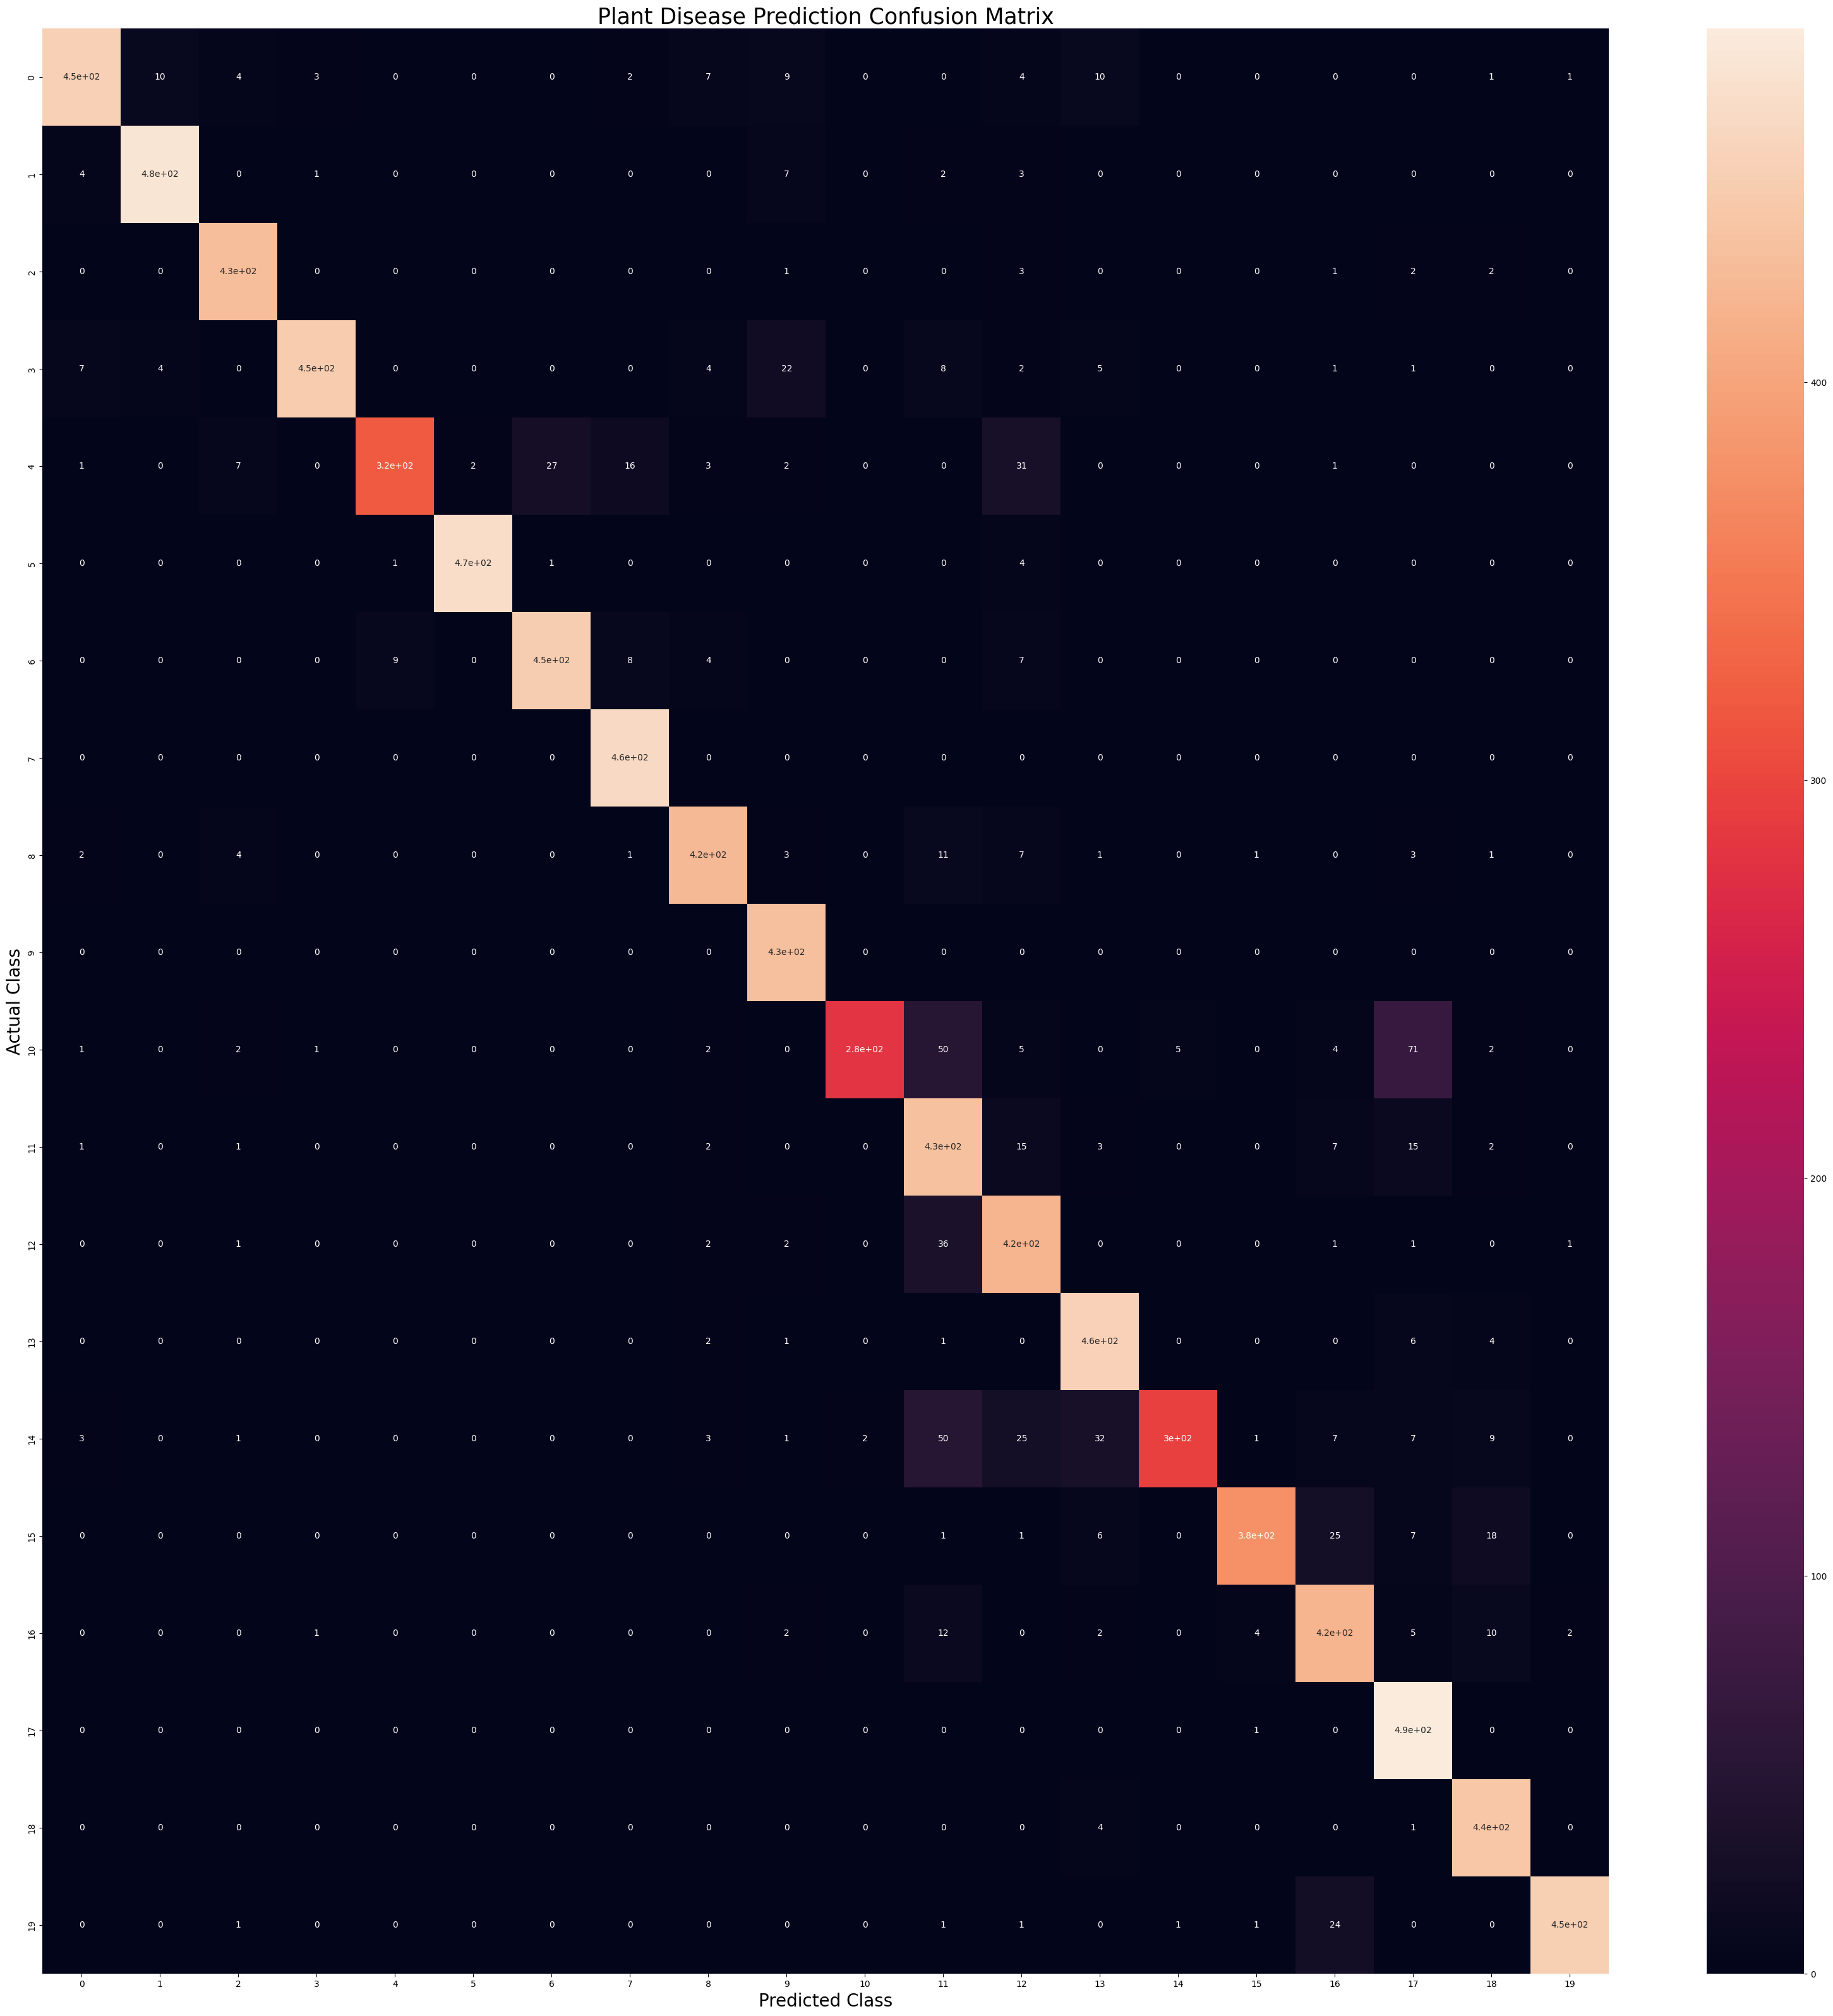

In [75]:
##Confusion Matrix Visualization
plt.figure(figsize=(40,40))
sns.heatmap(cm,annot=True,annot_kws={'size':10})
plt.xlabel("Predicted Class",fontsize=20)
plt.ylabel("Actual Class",fontsize=20)
plt.title("Plant Disease Prediction Confusion Matrix",fontsize=25)
plt.show()